Importing Necessary Library

In [1]:
# Importing Necessary Libraries
import wandb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Loading the Dataset

In [ ]:
# Initialize Weights & Biases
wandb.login(key="")
wandb.init(project="final-project-ablations", name="amuhairw_monkeypox-detection_run1")

# Loading the Dataset
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/kaggle/input/monkeypox-dataset/Monkeypox-dataset-2022/gray"))
data = []
labels = []

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amuhairw (delta-group-50). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[INFO] loading images...


In [3]:
for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # Load the image, swap color channels, and resize it to 224x224 pixels
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # Update the data and labels lists
    data.append(image)
    labels.append(label)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

Image preprocessing and extract the Label

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# labels = le.fit_transform(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42,stratify=labels)

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.02, 
    height_shift_range=0.02, 
    zoom_range=0.02, 
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [5]:
baseModel =VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# baseModel =ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
	# compile our model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# model.summary()

In [7]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [8]:
import tensorflow as tf
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# #opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR)
# opt = tf.keras.optimizers.RMSprop(learning_rate=INIT_LR)



# opt = Adam(learning_rate=INIT_LR) 

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [9]:
# compile our model
print("[INFO] compiling model...")
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
#model.compile(loss="hinge", optimizer=opt,
	#metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
import time
t1=time.process_time()
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
     callbacks=[wandb_callback]
)
t2 =time.process_time()
print("process time:", t2-t1)  
#model.save("vgg16.h5")

[INFO] compiling model...
[INFO] training head...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.4000 - loss: 0.7663 - val_accuracy: 0.5000 - val_loss: 0.6893
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6893
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.5222 - loss: 0.6753 - val_accuracy: 0.5625 - val_loss: 0.6761
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6761
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4778 - loss: 0.7171 - val_accuracy: 0.5625 - val_loss: 0.6683
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6683
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.6556 - loss: 0.6592 - val_accuracy: 0.5625 - val_loss: 0.6615
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6615
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5667 - loss: 0.6878 - val_accuracy: 0.6250 - val_loss: 0.6530
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_acc

In [10]:
print(len(H.history['loss']))

100


In [11]:
model.save_weights("my_model_weights.weights.h5")

In [12]:
# Log model weights to W&B as an artifact
artifact = wandb.Artifact("monkeypox-model", type="model")
artifact.add_file("my_model_weights.weights.h5")
wandb.log_artifact(artifact)

#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step
                   precision    recall  f1-score   support

   Monkeypox_gray       0.94      0.88      0.91        34
Normal_image_gray       0.86      0.92      0.89        26

         accuracy                           0.90        60
        macro avg       0.90      0.90      0.90        60
     weighted avg       0.90      0.90      0.90        60



In [13]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log metrics to W&B
wandb.log({
    "train_accuracy": acc,
    "train_sensitivity": sensitivity,
    "train_specificity": specificity
})

[[30  4]
 [ 2 24]]
acc: 0.9000
sensitivity: 0.8824
specificity: 0.9231


In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdys, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
                   precision    recall  f1-score   support

   Monkeypox_gray       0.88      0.78      0.82         9
Normal_image_gray       0.75      0.86      0.80         7

         accuracy                           0.81        16
        macro avg       0.81      0.82      0.81        16
     weighted avg       0.82      0.81      0.81        16



In [15]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log test metrics to W&B
wandb.log({
    "test_accuracy": acc,
    "test_sensitivity": sensitivity,
    "test_specificity": specificity
})

[[7 2]
 [1 6]]
acc: 0.8125
sensitivity: 0.7778
specificity: 0.8571


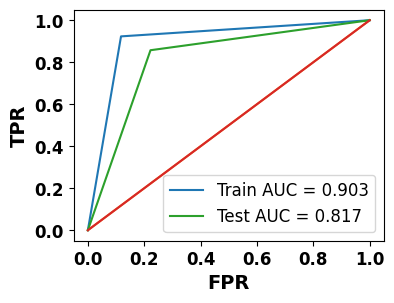

<Figure size 640x480 with 0 Axes>

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (4, 3))
fpr1,tpr1,_=roc_curve(np.argmax(trainY, axis=1),np.argmax(predIdxs, axis=1))
fpr2,tpr2,_=roc_curve(np.argmax(testY, axis=1),np.argmax(predIdys, axis=1))
area_under_curve1=auc(fpr1,tpr1)
random_probs=[0 for i in range(len(trainY.ravel()))]
p_fpr1,p_tpr1,threshold=roc_curve(trainY.ravel(),random_probs, pos_label=1)
plt.plot(fpr1,tpr1, label='Train AUC = {:.3f}'.format(area_under_curve1))
plt.plot(p_fpr1, p_tpr1)
area_under_curve2=auc(fpr2,tpr2)
random_probs2=[0 for i in range(len(testY.ravel()))]
p_fpr2,p_tpr2,threshold=roc_curve(testY.ravel(),random_probs2, pos_label=1)
plt.plot(fpr2,tpr2, label='Test AUC = {:.3f}'.format(area_under_curve2))
plt.plot(p_fpr2, p_tpr2)

    # x label
plt.xlabel('FPR',fontsize=14, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('TPR', fontsize=14, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
plt.legend()
plt.legend(prop={'size':12})
plt.savefig('ROC',dpi=200, bbox_inches='tight')
plt.show();

# Log ROC curve to W&B
wandb.log({"ROC_curve": wandb.Image(plt)})

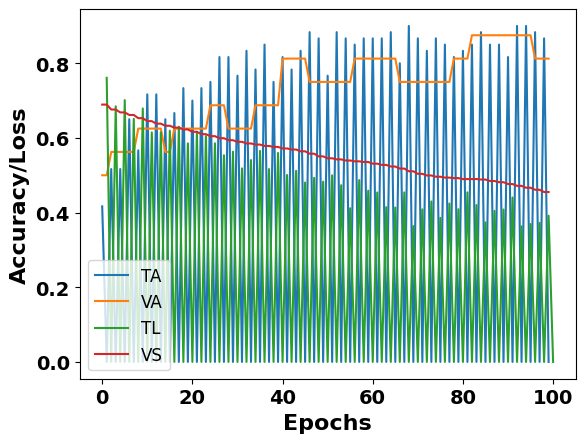

epoch/accuracy,▁▁▆▁▇▁▇▆▁▁▇▁▇▇█▁▇▁▁▇█▁█▁█▇▁█▁█▁█▁▇▁█▁▇▁█
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▁▇▁▇▁▁▇▁▁▇▁▆▁▁▇▁▁▆▁▆▁▅▁▆▁▅▁▁▁▅▁▅▁▅▅▁▁▁
epoch/val_accuracy,▁▁▂▂▂▃▃▃▂▃▃▅▅▅▃▅▅▅▅▇▇▇▇▆▆▆▆▆▇▇▆▆▆▇▇████▇
epoch/val_loss,████▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
test_accuracy,▁
test_sensitivity,▁
test_specificity,▁
train_accuracy,▁
train_sensitivity,▁


<Figure size 640x480 with 0 Axes>

In [17]:

from matplotlib.ticker import FormatStrFormatter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VS')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'size':12})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('ACC',dpi=200, bbox_inches='tight')
plt.show()

# Log accuracy/loss plot to W&B
wandb.log({"Accuracy_Loss_Plot": wandb.Image(plt)})

# Finish W&B run
wandb.finish()